In [1]:
import gzip
from tensorflow.keras.utils import to_categorical

In [2]:
# Useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import  Aer, transpile
from qiskit.circuit.library import CHGate
import qiskit

In [4]:
# EMNIST decoder

decoder = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [5]:
images_raw = gzip.open("data/EMNIST/gzip/emnist-balanced-train-images-idx3-ubyte.gz", "r")
labels_raw = gzip.open("data/EMNIST/gzip/emnist-balanced-train-labels-idx1-ubyte.gz")


image_size = 28
num_images = 256 # how many images per batch

images_raw.read(16) # reads the data type
labels_raw.read(8) # reads the data type

def get_data(images, labels):
    buf_images = images.read(image_size * image_size * num_images)
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(num_images, image_size, image_size, 1)
    
    buf_labels = labels.read(num_images)
    labels = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int32)
    
    return images, labels

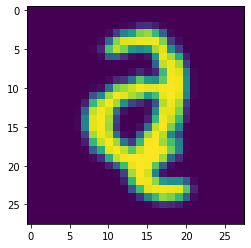

a


In [6]:
# print images
data = get_data(images_raw, labels_raw)

images = data[0]
labels = data[1]

image = np.asarray(images[1]).T.squeeze()
plt.imshow(image)
plt.show()

print(decoder[labels[1]])

In [7]:
def get_num_cls(data):
    labels = np.array(data[1])
    one_hot_labels = to_categorical(labels)
    
    return one_hot_labels.shape[1]


In [8]:
N = get_num_cls(data)
print(N)

47


In [55]:
class State_Prep:
    """see:
        https://arxiv.org/pdf/1908.08385.pdf
        equations 1 and 2
        also see:
        https://qiskit.org/documentation/stubs/qiskit.circuit.library.CHGate.html
    """
    def __init__(self, N, x):
        """"""
        self.N = 1
        self.target_N = N
        self.SU_of_N = np.asarray([[1]])
        # self.lie_algebra = 1
        self.x = x
        # self.mat = np.asarray([[0, -1j], [1j, 0]])
        self.alpha = np.arange(start=1, stop= self.target_N ** 2 + 1)
        self.K = 1
        self.P = self.K * np.exp(1j * np.asarray([[0, -1j], [1j, 0]])) * self.K


    
    def H(self):
        """"""
        h = np.zeros(shape=(self.target_N), dtype=np.complex_)
        for i in range(self.target_N):
            for k in range(self.target_N):
                h[i] += np.exp((1j * 2 * np.pi * i * k)  / self.target_N, dtype=np.complex_)
        
        return 1 / np.sqrt(self.target_N) * h
        
    def quNit(self):
        S3 = np.zeros(shape=(self.target_N, self.target_N))
        np.fill_diagonal(S3, val=-(self.target_N - 1) / 2)
        W = np.zeros(shape=self.x.shape) # learnable similar to weights
        sum_of_weights = np.sum(W @ self.x)
        print(sum_of_weights)
        Z = np.exp(1j * S3 * sum_of_weights)
        
        return Z * self.H() # need to use actual gate place holder
 ##################################################   
    
    def driver_for_SUG(self):
        """finds the value for alpha which is a self.target_N set"""
        
        
        print(self.SU_of_N.shape[0] * self.SU_of_N.shape[1])
        print(self.alpha.shape)
        
        return np.vdot(self.SU_of_N, self.alpha)
    
    
    def direct_sum(self, a, b):
        """"""
        if isinstance(a, int) and a == 1:
            a = np.asarray([a])[np.newaxis]

        # print("a = ", a)
        # print("b = ", b)
        # dsum = np.zeros( np.add(a.shape,b.shape), dtype=np.complex_ )
        # dsum[:a.shape[0],:a.shape[1]]=a
        # dsum[a.shape[0]:,a.shape[1]:]=b
        dsum = a + b
        # print(dsum)
        return dsum

    def A(self, k):
        return 1
        term1 = np.exp(1j * self.lie_algebra() * 3 * (self.a * 2 * k - 3))
        term2 = np.exp(1j * self.lie_algebra() * ((k-1) ** 2 + 1) ** self.a * (2 * (k - 1)))
        
        # print("term 1 = ", term1)
        # print("term2 = ", term2)
        
        term3 = np.vdot(term1, term2)
        
        # print("term3 = ", term3)
        
        return 1 # term3

    def lie_algebra(self):
        
        if self.N == 1:
            return 1
        if not isinstance(self.K, int):
            print(self.K.shape, "K lie")
            print(self.P.shape, "P lie")
        
        lie_alg = self.direct_sum(self.K,  self.P)
        
        print("lie", lie_alg.shape)
        
        return lie_alg
    
    def mat(self):
        if self.N > 1:
            n = self.N
            mat = np.zeros(shape=(n, n), dtype=np.complex_)
            mat[0, n - 1] = -1j
            mat[n - 1, 0] = 1j
            
        else:
            mat = np.asarray([[1]])
        print("mat", mat.shape)
        print(mat)
        
        return mat
        
    
    def Euler_angle_param(self):
        """"""
        print("RUN", self.N - 1)
        if self.N == self.target_N + 1:
            print("SU of N FOR {} FOUND".format(self.N - 1))
            return self.SU_of_N  
        

        if self.N <= 1:
            A = 1
        else:
            A = 1
            for i in self.alpha:
                self.a = i
                for k in range(self.target_N):
                    A *= self.A(k)
            # print(A.shape)
        
        self.N += 1
        lie_algebra = self.lie_algebra()
        self.P = self.K * np.exp(1j * self.mat()) * self.K
        

        try:
            print(self.K.shape, "K")
        except:
            print(self.K, "K")

        self.SU_of_N = self.K * lie_algebra # A
        self.K = self.Euler_angle_param()
        return self.SU_of_N
        
        
        
        #return self.Euler_angle_param()
    

In [56]:
vector_x = State_Prep(N, image)
output = vector_x.quNit()
print(output)


0.0
[[ 6.85565460e+00+0.00000000e+00j -2.59108275e-16+1.09311304e-16j
  -5.50605085e-16-8.90684696e-17j ...  1.82995219e-14+6.18621007e-15j
  -2.15383754e-15-2.06476907e-15j  2.88581842e-14+8.52223312e-15j]
 [ 6.85565460e+00+0.00000000e+00j -2.59108275e-16+1.09311304e-16j
  -5.50605085e-16-8.90684696e-17j ...  1.82995219e-14+6.18621007e-15j
  -2.15383754e-15-2.06476907e-15j  2.88581842e-14+8.52223312e-15j]
 [ 6.85565460e+00+0.00000000e+00j -2.59108275e-16+1.09311304e-16j
  -5.50605085e-16-8.90684696e-17j ...  1.82995219e-14+6.18621007e-15j
  -2.15383754e-15-2.06476907e-15j  2.88581842e-14+8.52223312e-15j]
 ...
 [ 6.85565460e+00+0.00000000e+00j -2.59108275e-16+1.09311304e-16j
  -5.50605085e-16-8.90684696e-17j ...  1.82995219e-14+6.18621007e-15j
  -2.15383754e-15-2.06476907e-15j  2.88581842e-14+8.52223312e-15j]
 [ 6.85565460e+00+0.00000000e+00j -2.59108275e-16+1.09311304e-16j
  -5.50605085e-16-8.90684696e-17j ...  1.82995219e-14+6.18621007e-15j
  -2.15383754e-15-2.06476907e-15j  2.885818

In [57]:
vector_x.Euler_angle_param()
print(vector_x.driver_for_SUG())

RUN 1
lie (2, 2)
mat (2, 2)
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]]
1 K
RUN 2
lie (2, 2)
mat (3, 3)
[[ 0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j]]
1 K
RUN 3
lie (3, 3)
mat (4, 4)
[[ 0.+0.j  0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j  0.+0.j]]
1 K
RUN 4
lie (4, 4)
mat (5, 5)
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
1 K
RUN 5
lie (5, 5)
mat (6, 6)
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
1 K
RUN 6
lie (6, 6)
mat (7, 7)
[[ 0.+0.j  0.+0.j  0.+0.j  

mat (23, 23)
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.

lie (31, 31)
mat (32, 32)
[[ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]]
1 K
RUN 32
lie (32, 32)
mat (33, 33)
[[ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]]
1 K
RUN 33
lie (33, 33)
mat (34, 34)
[[ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j -0.-1.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 